# test environment

In [13]:
import  sys 
sys.version

'2.7.12 (default, Dec  4 2017, 14:50:18) \n[GCC 5.4.0 20160609]'

In [2]:
import tensorflow
import keras

Using TensorFlow backend.


In [17]:
a=5
print type(a)

<type 'int'>


# import modules

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import time
import matplotlib.pyplot as plt
import hdf5storage
import scipy.io as scio
import h5py
%matplotlib inline

from keras.models import Sequential, model_from_json, Model, load_model
from keras.optimizers import SGD
from keras.layers import Input, Reshape, concatenate, Activation, Flatten, merge
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout
from keras import backend as K
from keras.callbacks import TensorBoard

Using TensorFlow backend.


# File paths

In [2]:
#设置当前目录
root = '/home/smiletranquilly/FYP/Multi-Scale_Deep_Network' 
os.chdir(root)

coarse_dir='./coarse_data/first_model.h5'
coarse_weights='./coarse_data/coarse_weights.h5'
fine_dir='./fine_data/first_model.h5'
fine_weights='./fine_data/fine_weights.h5'

log_filepath = './tmp/keras_log'
dataFile = '/home/download/nyu_depth_v2_labeled.mat'

isExists=os.path.exists('./coarse_data')
    # 判断结果
if not isExists:
    # 如果不存在则创建目录
    os.makedirs('./coarse_data') 
isExists=os.path.exists('./fine_data')
if not isExists:
    # 如果不存在则创建目录
    os.makedirs('./fine_data')
isExists=os.path.exists('./tmp')
if not isExists:
    # 如果不存在则创建目录
    os.makedirs('./tmp')
        

# Utillity functions

In [3]:
def scale_invarient_error(y_true,y_pred):
    log_1=K.log(K.clip(y_pred,K.epsilon(),np.inf)+1.)
    log_2=K.log(K.clip(y_true,K.epsilon(),np.inf)+1.)
    return K.mean(K.square(log_1-log_2),axis=-1)-Lambda*K.square(K.mean(log_1-log_2,axis=-1))

def pred_single_image_depth_using_fine(path):
    model=load_model(fine_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    img_array=cv2.imread(path)
    img_array=np.expand_dims(img_array,axis=0)
    img_array=np.array([cv2.resize(img_array[i],(480,640)) for i in range(1)])
    img_array=np.array([cv2.pyrDown(img_array[i]) for i in range(1)])
    img_array=rescale(img_array)
    out=model.predict(img_array)
    return out

def pred_single_image_depth_using_coarse(path):
    model=load_model(coarse_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    img_array=cv2.imread(path)
    img_array=np.expand_dims(img_array,axis=0)
    img_array=np.array([cv2.resize(img_array[i],(480,640)) for i in range(1)])
    img_array=np.array([cv2.pyrDown(img_array[i]) for i in range(1)])
    img_array=rescale(img_array)
    out=model.predict(img_array)
    return out

def pred_single_image_depth_using_coarse_array(image_array):
    model=load_model(coarse_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    image_array=np.expand_dims(image_array,axis=0)
    image_array=np.array([cv2.resize(image_array[i],(480,640)) for i in range(1)])
    image_array=np.array([cv2.pyrDown(image_array[i]) for i in range(1)])
    image_array=rescale(image_array)
    out=model.predict(image_array)
    return out

def pred_single_image_depth_using_fine_array(image_array):
    model=load_model(fine_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    image_array=np.expand_dims(image_array,axis=0)
    image_array=np.array([cv2.resize(image_array[i],(480,640)) for i in range(1)])
    image_array=np.array([cv2.pyrDown(image_array[i]) for i in range(1)])
    image_array=rescale(image_array)
    out=model.predict(image_array)
    return out
def display_image(path):
    img_array=plt.imread(path)
    img_array=np.expand_dims(img_array,axis=0) 
    img_array=np.array([cv2.resize(img_array[i],(480,640)) for i in range(1)])
    img_array=rescale(img_array)
    plt.imshow(img_array[0])
    
def eval(eval_dir):
    #load_model
    model=load_model(eval_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    print(model.evaluate(X_test,y_test))  
    
def rescale(data):
    data=data.astype('float32')
    data /= 255
    
    return data

#  LossHistory class，save loss and acc

In [ ]:

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

# load dataset and resize

In [4]:
def convert(mat,start,end):
# input must be matlab mat!
    X=[]
    y=[]
    img = mat['images'] #image
    depths = mat['depths'] # raw depths
    for i in range(start, end): # include left not right!
                img1 = img[i,...].transpose((1, 2, 0))
                img2 = depths[i]     #np.transpose() 
                X.append(img1)
                y.append(img2)
    return np.array(X),np.array(y)

# View data information

In [4]:
mat = h5py.File(dataFile)
print mat.keys()
print mat.values()

X_data=mat['images']
y_data=mat['rawDepths']
y2_data=mat['depths']
# view type
print type(X_data)
print type(y_data)

#view shape
print X_data.shape
print y_data.shape

print X_data.dtype


[u'#refs#', u'#subsystem#', u'accelData', u'depths', u'images', u'instances', u'labels', u'names', u'namesToIds', u'rawDepthFilenames', u'rawDepths', u'rawRgbFilenames', u'sceneTypes', u'scenes']
[<HDF5 group "/#refs#" (8484 members)>, <HDF5 group "/#subsystem#" (1 members)>, <HDF5 dataset "accelData": shape (4, 1449), type "<f4">, <HDF5 dataset "depths": shape (1449, 640, 480), type "<f4">, <HDF5 dataset "images": shape (1449, 3, 640, 480), type "|u1">, <HDF5 dataset "instances": shape (1449, 640, 480), type "|u1">, <HDF5 dataset "labels": shape (1449, 640, 480), type "<u2">, <HDF5 dataset "names": shape (1, 894), type "|O">, <HDF5 dataset "namesToIds": shape (1, 6), type "<u4">, <HDF5 dataset "rawDepthFilenames": shape (1, 1449), type "|O">, <HDF5 dataset "rawDepths": shape (1449, 640, 480), type "<f4">, <HDF5 dataset "rawRgbFilenames": shape (1, 1449), type "|O">, <HDF5 dataset "sceneTypes": shape (1, 1449), type "|O">, <HDF5 dataset "scenes": shape (1, 1449), type "|O">]
<class 'h5

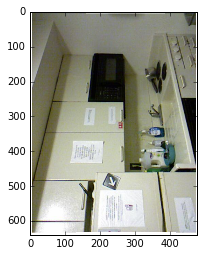

In [5]:
# A=np.array(X_data[0])
# print A.shape
# B=np.array(y_data[0])
#print X_data[1].shape
img = X_data[1].transpose((1, 2, 0))  
plt.imshow(img) 


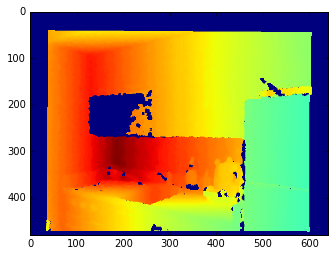

In [26]:
plt.imshow(np.transpose(y_data[1])) 

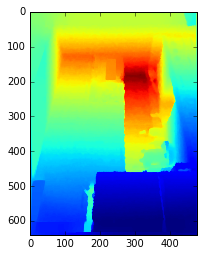

In [6]:
#y2_data[1].resize()
plt.imshow(y2_data[1]) #np.transpose()

In [7]:
del X_data,y_data,y2_data

# Feature engineering

In [5]:
mat = h5py.File(dataFile)
# number of the first dim
img = mat['images'] #image
depths = mat['depths'] # raw depths
image_num = len(img) 
depth_num = len(depths)
try:
    image_num == depth_num
except IOError:
    print "number not match, input error!"
    
X_1,y_1=convert(mat,0,image_num/3)
X_2,y_2=convert(mat,image_num/3,2*image_num/3)
X_3,y_3=convert(mat,2*image_num/3,image_num)
print(X_1.shape,y_1.shape)
print(X_2.shape,y_2.shape)
print(X_3.shape,y_3.shape)
X_4=np.concatenate((X_1,X_2),axis=0)
# release memory
del X_1,X_2
y_4=np.concatenate((y_1,y_2),axis=0)
del y_1,y_2
X_data=np.concatenate((X_4,X_3),axis=0)
del X_4,X_3
y_data=np.concatenate((y_4,y_3),axis=0)    
del y_4,y_3
#X_data,y_data,img_num = convert(dataFile)     

print(X_data.shape,y_data.shape)
# 归一化
X_data=rescale(X_data)
y_data=rescale(y_data)

((483, 640, 480, 3), (483, 640, 480))
((483, 640, 480, 3), (483, 640, 480))
((483, 640, 480, 3), (483, 640, 480))
((1449, 640, 480, 3), (1449, 640, 480))


# Resize

In [11]:
# X_data=np.array([cv2.resize(X_data[i],(480,640)) for i in range(image_num)])
# y_data=np.array([cv2.resize(y_data[i],(480,640)) for i in range(image_num)])

MemoryError: 

# Training/testing data

In [6]:
train_end=int(0.6*image_num)
test_num= image_num - train_end
X_train=X_data[:train_end]
y_train=y_data[:train_end]

X_test=X_data[train_end:image_num]
y_test=y_data[train_end:image_num]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train=np.array([cv2.pyrDown(X_train[i]) for i in range(train_end)])
y_train=np.array([cv2.pyrDown(y_train[i]) for i in range(train_end)])
X_test=np.array([cv2.pyrDown(X_test[i]) for i in range(test_num)])
y_test=np.array([cv2.pyrDown(y_test[i]) for i in range(test_num)])

y_train=np.array([cv2.pyrDown(y_train[i]) for i in range(train_end)])
y_test=np.array([cv2.pyrDown(y_test[i]) for i in range(test_num)])
y_train=np.array([cv2.pyrDown(y_train[i]) for i in range(train_end)])
y_test=np.array([cv2.pyrDown(y_test[i]) for i in range(test_num)])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(869, 640, 480, 3)
(869, 640, 480)
(580, 640, 480, 3)
(580, 640, 480)
(869, 320, 240, 3)
(869, 80, 60)
(580, 320, 240, 3)
(580, 80, 60)


## 图像金字塔主要有两类：高斯金字塔和拉普拉斯金字塔。 

高斯金字塔的顶部是通过将底部图像的连续行与列去掉得到的。每一层图像中的像素值等于下一层图像中对应位置5个像素的高斯加权平均值。这样操作一个M*N的图像就变成了(M/2)*(N/2)的图像，图像的面积就变为原来的1/4，连续进行这样的操作，就会得到一些列的金字塔的图像。Opencv中可以通过函数cv2.pyrDown()和cv2.pyrUp()来构建金字塔。函数cv2.pyrDown()是从一个高分辨率图像变成低分辨率图像的。cv2.pyrDown()函数接受3个参数：

tmp: 当前图像，初始化为原图像 src 。
dst: 目的图像( 显示图像，为输入图像的一半)
Size( tmp.cols/2, tmp.rows/2 ) :目的图像大小， 既然我们是向下采样
默认情况下直接输入需要操作的图像就可以，他会把图像按缩小1/4的来处理。

# Configurations

In [7]:
batch_size=32
epochs=1000
img_row=640
img_cols=480
learning_rate=0.1
momentum=0.9
Lambda=0.5

# Deep Network

## coarse network

In [6]:
def train_coarse():
    inputs=Input(shape=(int(img_row/2),int(img_cols/2),3))

    #coarse_1
    coarse_1=Convolution2D(96,(11,11),strides=(4,4),padding='same')(inputs)
    coarse_1=Activation('relu')(coarse_1)
    coarse_1=MaxPooling2D(pool_size=(2, 2))(coarse_1)

    #coarse_2
    coarse_2=Convolution2D(256,(5,5),padding='same')(coarse_1)
    coarse_2=Activation('relu')(coarse_2)
    coarse_2=MaxPooling2D(pool_size=(2,2))(coarse_2)

    #coarse_3
    coarse_3=Convolution2D(384,(3,3),padding='same')(coarse_2)
    coarse_3=Activation('relu')(coarse_3)

    #coarse_4
    coarse_4=Convolution2D(384,(3,3),padding='same')(coarse_3)
    coarse_4=Activation('relu')(coarse_4)

    #coarse_5
    coarse_5=Convolution2D(256,(3,3),padding='same',)(coarse_4)
    coarse_5=Activation('relu')(coarse_5)
    coarse_5=MaxPooling2D(pool_size=(2,2))(coarse_5)

    #coarse_6
    coarse_6=Flatten(name='coarse_6')(coarse_5)
    coarse_6=Dense(4096)(coarse_6)
    coarse_6=Activation('relu')(coarse_6)
    coarse_6=Dropout(0.5)(coarse_6)

    # Coarse 7
    coarse_7=Dense((int(img_row/8))*(int(img_cols/8)))(coarse_6)
    coarse_7=Activation('linear')(coarse_7)
    coarse_7=Reshape((int(img_row/8),int(img_cols/8)))(coarse_7)
        
    model=Model(input=inputs,output=coarse_7)
    model.compile(loss=scale_invarient_error,optimizer=SGD(learning_rate,momentum),metrics=['accuracy'])
    
    #print model
    model.summary() 
    
#     #创建一个实例history
#     history = LossHistory()   
                               
    model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,callbacks=[TensorBoard(log_dir=log_filepath)])
                               
    #save_model
    model.save(coarse_dir)
    
#     #绘制acc-loss曲线
#     history.loss_plot('epoch')

### model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

注意：

loss后类似’binary_crossentropy’、’mse’等代称

loss为函数名称的时候，不带括号

函数参数必须为(y_true, y_pred, **kwards)的格式

不能直接使用tf.nn.sigmoid_cross_entropy_with_logits等函数，因为其参数格式为(labels=None, 
logits=None)，需要指定labels=、logits=这两个参数

## Run_coarse

In [9]:
%time
train_coarse()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 240, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 60, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 80, 60, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 30, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 30, 256)       614656    
_________________________________________________________________
activation_2 (Activation)    (None, 40, 30, 256)       0         
_________________________________________________________________
max_pooling2

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("re..., inputs=Tensor("in...)`


Train on 695 samples, validate on 174 samples
Epoch 1/1000
695/695 [==============================] - 9s 13ms/step - loss: 1.5263e-04 - acc: 0.0155 - val_loss: 6.3717e-05 - val_acc: 0.0149
Epoch 2/1000
695/695 [==============================] - 7s 9ms/step - loss: 7.1098e-05 - acc: 0.0154 - val_loss: 6.1902e-05 - val_acc: 0.0165
Epoch 3/1000
695/695 [==============================] - 7s 10ms/step - loss: 6.7850e-05 - acc: 0.0165 - val_loss: 6.1950e-05 - val_acc: 0.0156
Epoch 4/1000
695/695 [==============================] - 7s 10ms/step - loss: 6.7320e-05 - acc: 0.0174 - val_loss: 6.1959e-05 - val_acc: 0.0154
Epoch 5/1000
695/695 [==============================] - 7s 10ms/step - loss: 6.7057e-05 - acc: 0.0164 - val_loss: 6.1921e-05 - val_acc: 0.0161
Epoch 6/1000
695/695 [==============================] - 7s 10ms/step - loss: 6.6875e-05 - acc: 0.0171 - val_loss: 6.1851e-05 - val_acc: 0.0166
Epoch 7/1000
695/695 [==============================] - 7s 10ms/step - loss: 6.6724e-05 - acc: 0.

Epoch 114/1000
695/695 [==============================] - 7s 10ms/step - loss: 5.3875e-05 - acc: 0.0213 - val_loss: 4.6653e-05 - val_acc: 0.0257
Epoch 115/1000
695/695 [==============================] - 7s 10ms/step - loss: 5.3715e-05 - acc: 0.0228 - val_loss: 4.6494e-05 - val_acc: 0.0254
Epoch 116/1000
695/695 [==============================] - 7s 10ms/step - loss: 5.3571e-05 - acc: 0.0229 - val_loss: 4.6351e-05 - val_acc: 0.0261
Epoch 117/1000
695/695 [==============================] - 7s 10ms/step - loss: 5.3415e-05 - acc: 0.0235 - val_loss: 4.6194e-05 - val_acc: 0.0259
Epoch 118/1000
695/695 [==============================] - 7s 10ms/step - loss: 5.3270e-05 - acc: 0.0217 - val_loss: 4.6043e-05 - val_acc: 0.0260
Epoch 119/1000
695/695 [==============================] - 7s 10ms/step - loss: 5.3145e-05 - acc: 0.0225 - val_loss: 4.5905e-05 - val_acc: 0.0260
Epoch 120/1000
695/695 [==============================] - 7s 10ms/step - loss: 5.2945e-05 - acc: 0.0226 - val_loss: 4.5751e-05 - v

695/695 [==============================] - 7s 9ms/step - loss: 3.6921e-05 - acc: 0.0238 - val_loss: 3.0804e-05 - val_acc: 0.0323
Epoch 227/1000
695/695 [==============================] - 7s 10ms/step - loss: 3.6798e-05 - acc: 0.0238 - val_loss: 3.0687e-05 - val_acc: 0.0319
Epoch 228/1000
695/695 [==============================] - 7s 10ms/step - loss: 3.6676e-05 - acc: 0.0233 - val_loss: 3.0572e-05 - val_acc: 0.0315
Epoch 229/1000
695/695 [==============================] - 7s 10ms/step - loss: 3.6531e-05 - acc: 0.0237 - val_loss: 3.0454e-05 - val_acc: 0.0313
Epoch 230/1000
695/695 [==============================] - 7s 10ms/step - loss: 3.6418e-05 - acc: 0.0244 - val_loss: 3.0342e-05 - val_acc: 0.0312
Epoch 231/1000
695/695 [==============================] - 7s 10ms/step - loss: 3.6264e-05 - acc: 0.0229 - val_loss: 3.0225e-05 - val_acc: 0.0313
Epoch 232/1000
695/695 [==============================] - 7s 9ms/step - loss: 3.6133e-05 - acc: 0.0227 - val_loss: 3.0117e-05 - val_acc: 0.0311
Ep

Epoch 283/1000
695/695 [==============================] - 7s 9ms/step - loss: 3.0566e-05 - acc: 0.0230 - val_loss: 2.5252e-05 - val_acc: 0.0328
Epoch 284/1000
695/695 [==============================] - 7s 9ms/step - loss: 3.0468e-05 - acc: 0.0241 - val_loss: 2.5172e-05 - val_acc: 0.0325
Epoch 285/1000
695/695 [==============================] - 7s 9ms/step - loss: 3.0378e-05 - acc: 0.0233 - val_loss: 2.5092e-05 - val_acc: 0.0330
Epoch 286/1000
695/695 [==============================] - 7s 9ms/step - loss: 3.0309e-05 - acc: 0.0237 - val_loss: 2.5015e-05 - val_acc: 0.0327
Epoch 287/1000
695/695 [==============================] - 7s 9ms/step - loss: 3.0184e-05 - acc: 0.0225 - val_loss: 2.4940e-05 - val_acc: 0.0327
Epoch 288/1000
695/695 [==============================] - 7s 9ms/step - loss: 3.0110e-05 - acc: 0.0246 - val_loss: 2.4860e-05 - val_acc: 0.0325
Epoch 289/1000
695/695 [==============================] - 7s 9ms/step - loss: 3.0021e-05 - acc: 0.0238 - val_loss: 2.4784e-05 - val_acc:

Epoch 340/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.6164e-05 - acc: 0.0232 - val_loss: 2.1557e-05 - val_acc: 0.0315
Epoch 341/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.6106e-05 - acc: 0.0237 - val_loss: 2.1505e-05 - val_acc: 0.0315
Epoch 342/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.6055e-05 - acc: 0.0236 - val_loss: 2.1453e-05 - val_acc: 0.0314
Epoch 343/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.5987e-05 - acc: 0.0231 - val_loss: 2.1405e-05 - val_acc: 0.0310
Epoch 344/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.5923e-05 - acc: 0.0231 - val_loss: 2.1355e-05 - val_acc: 0.0308
Epoch 345/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.5870e-05 - acc: 0.0235 - val_loss: 2.1306e-05 - val_acc: 0.0301
Epoch 346/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.5808e-05 - acc: 0.0232 - val_loss: 2.1256e-05 - val_acc:

Epoch 397/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.3247e-05 - acc: 0.0214 - val_loss: 1.9240e-05 - val_acc: 0.0290
Epoch 398/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.3201e-05 - acc: 0.0240 - val_loss: 1.9210e-05 - val_acc: 0.0287
Epoch 399/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.3160e-05 - acc: 0.0223 - val_loss: 1.9179e-05 - val_acc: 0.0288
Epoch 400/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.3123e-05 - acc: 0.0230 - val_loss: 1.9148e-05 - val_acc: 0.0289
Epoch 401/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.3077e-05 - acc: 0.0229 - val_loss: 1.9119e-05 - val_acc: 0.0290
Epoch 402/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.3050e-05 - acc: 0.0234 - val_loss: 1.9089e-05 - val_acc: 0.0288
Epoch 403/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.2999e-05 - acc: 0.0224 - val_loss: 1.9059e-05 - val_acc:

Epoch 454/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.1376e-05 - acc: 0.0224 - val_loss: 1.7880e-05 - val_acc: 0.0290
Epoch 455/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.1345e-05 - acc: 0.0230 - val_loss: 1.7862e-05 - val_acc: 0.0288
Epoch 456/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.1320e-05 - acc: 0.0238 - val_loss: 1.7845e-05 - val_acc: 0.0288
Epoch 457/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.1290e-05 - acc: 0.0233 - val_loss: 1.7827e-05 - val_acc: 0.0288
Epoch 458/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.1264e-05 - acc: 0.0231 - val_loss: 1.7808e-05 - val_acc: 0.0287
Epoch 459/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.1238e-05 - acc: 0.0225 - val_loss: 1.7793e-05 - val_acc: 0.0288
Epoch 460/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.1203e-05 - acc: 0.0232 - val_loss: 1.7776e-05 - val_acc:

Epoch 511/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.0128e-05 - acc: 0.0237 - val_loss: 1.7055e-05 - val_acc: 0.0310
Epoch 512/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.0103e-05 - acc: 0.0246 - val_loss: 1.7046e-05 - val_acc: 0.0307
Epoch 513/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.0092e-05 - acc: 0.0243 - val_loss: 1.7034e-05 - val_acc: 0.0307
Epoch 514/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.0067e-05 - acc: 0.0232 - val_loss: 1.7024e-05 - val_acc: 0.0308
Epoch 515/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.0047e-05 - acc: 0.0231 - val_loss: 1.7014e-05 - val_acc: 0.0308
Epoch 516/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.0034e-05 - acc: 0.0234 - val_loss: 1.7004e-05 - val_acc: 0.0310
Epoch 517/1000
695/695 [==============================] - 7s 9ms/step - loss: 2.0018e-05 - acc: 0.0234 - val_loss: 1.6993e-05 - val_acc:

Epoch 568/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.9295e-05 - acc: 0.0243 - val_loss: 1.6568e-05 - val_acc: 0.0327
Epoch 569/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.9287e-05 - acc: 0.0237 - val_loss: 1.6562e-05 - val_acc: 0.0328
Epoch 570/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.9273e-05 - acc: 0.0243 - val_loss: 1.6556e-05 - val_acc: 0.0328
Epoch 571/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.9267e-05 - acc: 0.0244 - val_loss: 1.6549e-05 - val_acc: 0.0328
Epoch 572/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.9241e-05 - acc: 0.0245 - val_loss: 1.6543e-05 - val_acc: 0.0325
Epoch 573/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.9242e-05 - acc: 0.0236 - val_loss: 1.6537e-05 - val_acc: 0.0325
Epoch 574/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.9220e-05 - acc: 0.0241 - val_loss: 1.6530e-05 - val_acc:

Epoch 625/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8730e-05 - acc: 0.0243 - val_loss: 1.6271e-05 - val_acc: 0.0343
Epoch 626/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8723e-05 - acc: 0.0245 - val_loss: 1.6267e-05 - val_acc: 0.0341
Epoch 627/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8712e-05 - acc: 0.0234 - val_loss: 1.6262e-05 - val_acc: 0.0342
Epoch 628/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8706e-05 - acc: 0.0240 - val_loss: 1.6257e-05 - val_acc: 0.0341
Epoch 629/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8696e-05 - acc: 0.0248 - val_loss: 1.6253e-05 - val_acc: 0.0338
Epoch 630/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8687e-05 - acc: 0.0243 - val_loss: 1.6248e-05 - val_acc: 0.0337
Epoch 631/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8672e-05 - acc: 0.0237 - val_loss: 1.6243e-05 - val_acc:

Epoch 682/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8306e-05 - acc: 0.0235 - val_loss: 1.6063e-05 - val_acc: 0.0323
Epoch 683/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8297e-05 - acc: 0.0238 - val_loss: 1.6061e-05 - val_acc: 0.0320
Epoch 684/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8291e-05 - acc: 0.0247 - val_loss: 1.6058e-05 - val_acc: 0.0318
Epoch 685/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8283e-05 - acc: 0.0245 - val_loss: 1.6056e-05 - val_acc: 0.0318
Epoch 686/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8279e-05 - acc: 0.0245 - val_loss: 1.6054e-05 - val_acc: 0.0320
Epoch 687/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8272e-05 - acc: 0.0245 - val_loss: 1.6051e-05 - val_acc: 0.0320
Epoch 688/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8270e-05 - acc: 0.0246 - val_loss: 1.6049e-05 - val_acc:

Epoch 739/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8036e-05 - acc: 0.0254 - val_loss: 1.5964e-05 - val_acc: 0.0305
Epoch 740/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8027e-05 - acc: 0.0245 - val_loss: 1.5963e-05 - val_acc: 0.0305
Epoch 741/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8026e-05 - acc: 0.0265 - val_loss: 1.5961e-05 - val_acc: 0.0304
Epoch 742/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8021e-05 - acc: 0.0242 - val_loss: 1.5960e-05 - val_acc: 0.0304
Epoch 743/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8016e-05 - acc: 0.0239 - val_loss: 1.5959e-05 - val_acc: 0.0302
Epoch 744/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8011e-05 - acc: 0.0260 - val_loss: 1.5957e-05 - val_acc: 0.0300
Epoch 745/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.8010e-05 - acc: 0.0240 - val_loss: 1.5956e-05 - val_acc:

Epoch 796/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7844e-05 - acc: 0.0253 - val_loss: 1.5908e-05 - val_acc: 0.0302
Epoch 797/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7833e-05 - acc: 0.0250 - val_loss: 1.5907e-05 - val_acc: 0.0303
Epoch 798/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7829e-05 - acc: 0.0241 - val_loss: 1.5907e-05 - val_acc: 0.0302
Epoch 799/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7829e-05 - acc: 0.0249 - val_loss: 1.5906e-05 - val_acc: 0.0303
Epoch 800/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7824e-05 - acc: 0.0249 - val_loss: 1.5905e-05 - val_acc: 0.0304
Epoch 801/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7825e-05 - acc: 0.0241 - val_loss: 1.5904e-05 - val_acc: 0.0304
Epoch 802/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7824e-05 - acc: 0.0257 - val_loss: 1.5903e-05 - val_acc:

Epoch 853/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7699e-05 - acc: 0.0245 - val_loss: 1.5878e-05 - val_acc: 0.0311
Epoch 854/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7695e-05 - acc: 0.0245 - val_loss: 1.5878e-05 - val_acc: 0.0310
Epoch 855/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7697e-05 - acc: 0.0254 - val_loss: 1.5878e-05 - val_acc: 0.0310
Epoch 856/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7689e-05 - acc: 0.0253 - val_loss: 1.5877e-05 - val_acc: 0.0309
Epoch 857/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7688e-05 - acc: 0.0260 - val_loss: 1.5877e-05 - val_acc: 0.0311
Epoch 858/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7690e-05 - acc: 0.0244 - val_loss: 1.5877e-05 - val_acc: 0.0311
Epoch 859/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7685e-05 - acc: 0.0267 - val_loss: 1.5876e-05 - val_acc:

Epoch 910/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7598e-05 - acc: 0.0258 - val_loss: 1.5869e-05 - val_acc: 0.0324
Epoch 911/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7599e-05 - acc: 0.0252 - val_loss: 1.5869e-05 - val_acc: 0.0323
Epoch 912/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7600e-05 - acc: 0.0263 - val_loss: 1.5869e-05 - val_acc: 0.0323
Epoch 913/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7601e-05 - acc: 0.0250 - val_loss: 1.5869e-05 - val_acc: 0.0320
Epoch 914/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7599e-05 - acc: 0.0262 - val_loss: 1.5869e-05 - val_acc: 0.0322
Epoch 915/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7593e-05 - acc: 0.0265 - val_loss: 1.5869e-05 - val_acc: 0.0324
Epoch 916/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7595e-05 - acc: 0.0263 - val_loss: 1.5869e-05 - val_acc:

Epoch 967/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7536e-05 - acc: 0.0266 - val_loss: 1.5872e-05 - val_acc: 0.0320
Epoch 968/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7534e-05 - acc: 0.0263 - val_loss: 1.5873e-05 - val_acc: 0.0321
Epoch 969/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7537e-05 - acc: 0.0253 - val_loss: 1.5872e-05 - val_acc: 0.0321
Epoch 970/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7532e-05 - acc: 0.0252 - val_loss: 1.5873e-05 - val_acc: 0.0322
Epoch 971/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7529e-05 - acc: 0.0266 - val_loss: 1.5873e-05 - val_acc: 0.0322
Epoch 972/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7534e-05 - acc: 0.0264 - val_loss: 1.5873e-05 - val_acc: 0.0322
Epoch 973/1000
695/695 [==============================] - 7s 9ms/step - loss: 1.7531e-05 - acc: 0.0266 - val_loss: 1.5873e-05 - val_acc:

## Fine_layers

In [7]:
def train_fine():
    #load_coarse_model:
    model=load_model(coarse_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    
    for layers in model.layers:
        layers.trainable=False
    
    #fine_model
    inputs=model.input
    
    #fine_1:
    fine_1=Convolution2D(63,(9,9),strides=(2,2),padding='same')(inputs)
    fine_1=Activation('relu')(fine_1)
    fine_1=MaxPooling2D(pool_size=(2,2))(fine_1)
    
    #fine_2:
    coarse_output=model.output
    coarse_output=Reshape((int(img_row/8),int(img_cols/8),1))(coarse_output)
    fine_2=concatenate([fine_1,coarse_output],axis=3)
    
    #fine_3:
    fine_3=Convolution2D(64,(5,5),padding='same')(fine_2)
    fine_3=Activation('relu')(fine_3)
    
    #fine_4:
    fine_4=Convolution2D(1,(5,5),padding='same')(fine_3)
    fine_4=Activation('linear')(fine_4)
    fine_4=Reshape((int(img_row/8),int(img_cols/8)))(fine_4)
    
    model=Model(input=inputs,output=fine_4)
    model.compile(loss=scale_invarient_error,optimizer=SGD(learning_rate,momentum),metrics=['accuracy'])
    
    model.summary()
    
    
    model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,callbacks=[TensorBoard(log_dir='./tmp/fine_log')])
    
    #save model
    model.save(fine_dir)

## run fine_network¶

In [13]:
%time
train_fine()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("re..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 60, 96)   34944       input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 80, 60, 96)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 40, 30, 96)   0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

695/695 [==============================] - 6s 8ms/step - loss: 7.8333e-05 - acc: 0.0325 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 12/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8333e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 13/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8332e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 14/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8332e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 15/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8332e-05 - acc: 0.0325 - val_loss: 7.2147e-05 - val_acc: 0.0323
Epoch 16/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8332e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0323
Epoch 17/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8332e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0323
Epoch 18/1000

695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 126/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 127/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0323
Epoch 128/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0323
Epoch 129/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0323
Epoch 130/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0323
Epoch 131/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0323
Epoch 1

Epoch 182/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 183/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 184/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 185/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 186/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 187/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0324
Epoch 188/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc:

Epoch 239/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0325 - val_loss: 7.2147e-05 - val_acc: 0.0322
Epoch 240/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0322
Epoch 241/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0322
Epoch 242/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0327 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 243/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 244/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 245/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0326 - val_loss: 7.2147e-05 - val_acc:

Epoch 296/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0325 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 297/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0325 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 298/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0325 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 299/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0325 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 300/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0325 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 301/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0324 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 302/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0325 - val_loss: 7.2147e-05 - val_acc:

Epoch 353/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0323 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 354/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0324 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 355/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0323 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 356/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0323 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 357/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0324 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 358/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0324 - val_loss: 7.2147e-05 - val_acc: 0.0320
Epoch 359/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0323 - val_loss: 7.2147e-05 - val_acc:

Epoch 410/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0322 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 411/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0321 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 412/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0322 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 413/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0322 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 414/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0321 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 415/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0321 - val_loss: 7.2147e-05 - val_acc: 0.0321
Epoch 416/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0322 - val_loss: 7.2147e-05 - val_acc:

Epoch 467/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0320 - val_loss: 7.2147e-05 - val_acc: 0.0315
Epoch 468/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0319 - val_loss: 7.2147e-05 - val_acc: 0.0315
Epoch 469/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0320 - val_loss: 7.2147e-05 - val_acc: 0.0315
Epoch 470/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0320 - val_loss: 7.2147e-05 - val_acc: 0.0315
Epoch 471/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0320 - val_loss: 7.2147e-05 - val_acc: 0.0315
Epoch 472/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0320 - val_loss: 7.2147e-05 - val_acc: 0.0315
Epoch 473/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0320 - val_loss: 7.2147e-05 - val_acc:

Epoch 524/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0319 - val_loss: 7.2147e-05 - val_acc: 0.0313
Epoch 525/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0319 - val_loss: 7.2147e-05 - val_acc: 0.0313
Epoch 526/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0319 - val_loss: 7.2147e-05 - val_acc: 0.0313
Epoch 527/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0319 - val_loss: 7.2147e-05 - val_acc: 0.0313
Epoch 528/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0319 - val_loss: 7.2147e-05 - val_acc: 0.0313
Epoch 529/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0319 - val_loss: 7.2147e-05 - val_acc: 0.0313
Epoch 530/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0319 - val_loss: 7.2147e-05 - val_acc:

Epoch 581/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0318 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 582/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0318 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 583/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0318 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 584/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0318 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 585/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0318 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 586/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0318 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 587/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8331e-05 - acc: 0.0318 - val_loss: 7.2147e-05 - val_acc:

Epoch 638/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0317 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 639/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0317 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 640/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0317 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 641/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0317 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 642/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0317 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 643/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0317 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 644/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0316 - val_loss: 7.2147e-05 - val_acc:

Epoch 695/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0316 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 696/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0316 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 697/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0316 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 698/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0316 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 699/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0316 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 700/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0316 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 701/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc:

Epoch 752/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 753/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 754/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 755/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 756/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 757/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 758/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc:

Epoch 809/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 810/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 811/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 812/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 813/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 814/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0308
Epoch 815/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc:

Epoch 866/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 867/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 868/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 869/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 870/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 871/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc: 0.0307
Epoch 872/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0315 - val_loss: 7.2147e-05 - val_acc:

Epoch 923/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0313 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 924/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 925/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0313 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 926/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0313 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 927/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 928/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 929/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc:

Epoch 980/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 981/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 982/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0313 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 983/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 984/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0313 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 985/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0313 - val_loss: 7.2147e-05 - val_acc: 0.0309
Epoch 986/1000
695/695 [==============================] - 6s 8ms/step - loss: 7.8330e-05 - acc: 0.0314 - val_loss: 7.2147e-05 - val_acc:

# Evaluation

In [14]:
eval(coarse_dir)

580/580 [==============================] - 2s 3ms/step
[1.3691052324780872e-05, 0.03331896590775457]


本函数返回一个测试误差的标量值（如果模型没有其他评价指标），或一个标量的list（如果模型还有其他的评价指标）

In [15]:
eval(fine_dir)

580/580 [==============================] - 3s 5ms/step
[8.55802135353362e-05, 0.024590517028138557]


cv2中的色彩排列是(b,g,r)，而matplotlib库中的排列方式是(r,g,b)

# Examples

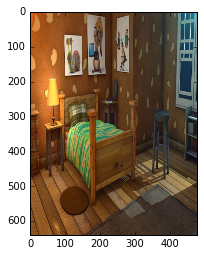

In [16]:
img_path = '/home/download/bedroom.jpg'
display_image(img_path)

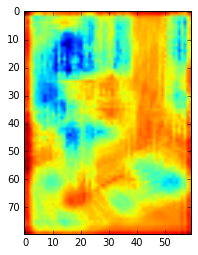

In [17]:
ans=pred_single_image_depth_using_fine(img_path)
plt.imshow(ans[0])

In [10]:
Img_path='/home/smiletranquilly/picture/test.png'
display_image(Img_path)
# DSM=pred_single_image_depth_using_fine(Img_path)
# plt.imshow(DSM[0])

NameError: name 'img_path' is not defined

In [4]:
import keras  
print keras.__version__

2.1.6
